## This is a new notebook, 10/31/2023 at 3:30pm. 
The previous code didn't work well if there was more than one small object overlapping on a big object. So we're going to try to fix that.

Todo:
1.) Restructure code to work with multipe overlaps on the same object
2.) Clean up the code
3.) Dask the code

In [1]:
import numpy as np
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.draw import ellipsoid
from skimage.draw import disk
from scipy import ndimage
#import napari
import matplotlib.pyplot as plt
#from functions import sphere_maker, return_overlap_segmentation, return_overlapping_pixels, overlapping_objects_with_size, remove_objects, get_overlap, get_object_size
import pandas as pd
import time
from scipy.sparse import coo_array
import sys

In [2]:
def sphere_maker(coords, Img, Label):
    y_I = coords[0]
    x_I = coords[1]
    z_I = coords[2]
    r = coords[3]
    #x_I, y_I, z_I are the center of the sphere
    #r is the radius
    
    z_Top = z_I+r # top most plane there will be a circle in
    z_Bottom = z_I-r # bottom most plane there will be a circle in
    
    for z in range(z_Bottom, z_Top+1):
        x = np.sqrt((r**2 - (z-z_I)**2)) # x is the new radius for this slice. 
        rr, cc = disk((y_I, x_I), x)
        Img[rr,cc,z]=Label
        
    return Img


/camp/home/fallest/.local/lib/python3.9/site-packages/skimage/draw/draw.py:41: RuntimeWarning: invalid value encountered in divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
/camp/home/fallest/.local/lib/python3.9/site-packages/skimage/draw/draw.py:42: RuntimeWarning: invalid value encountered in divide
  + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2


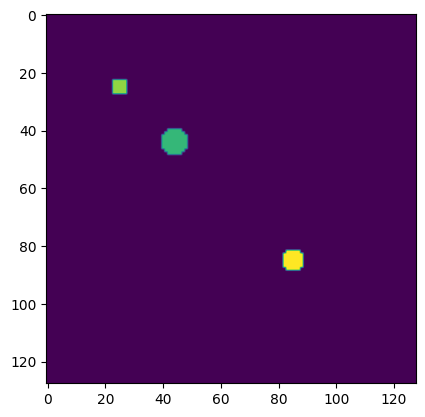

In [3]:
x = 128 #columns
y = 128 #rows
z = 20 #slices

dims = (y,x,z) #make an argument for the dimensions
Img_A = np.zeros(dims) # initialize Image A as zeros
Img_B = np.zeros(dims) # initialize Image B as zeros
Img_compare = np.zeros(dims)

####
# Set up the coordinates and radius of the centers of the 'nuclei'
# nuclei in A: coords = x, y, z centers, radius (x,y,z,r)
nuc_A_1 = (42, 42, 6, 6) # overlapping label with B1
nuc_A_2 = (100,100, 4, 3)
nuc_A_3 = (75, 75, 6, 4) # close to B3
nuc_A_4 = (23, 23, 4, 3)
nuc_A_5 = (21, 21, 4, 3)

# nuclei in B: coords = x, y, z centers, radius (x,y,z,r)
nuc_B_1 = (44, 44, 6, 5) # overlapping label with A1
nuc_B_2 = (25,25, 4, 3)
nuc_B_3 = (85, 85, 6, 4) # close to A3

Img_A = sphere_maker(nuc_A_1, Img_A, 1)
Img_A = sphere_maker(nuc_A_2, Img_A, 2)
Img_A = sphere_maker(nuc_A_3, Img_A, 3)
Img_A = sphere_maker(nuc_A_4, Img_A, 7)
Img_A = sphere_maker(nuc_A_5, Img_A, 8)

Img_B = sphere_maker(nuc_B_1, Img_B, 4)
Img_B = sphere_maker(nuc_B_2, Img_B, 5)
Img_B = sphere_maker(nuc_B_3, Img_B, 6)

plt.imshow(Img_A[:,:,5])
plt.imshow(Img_B[:,:,5])

In [4]:
def return_overlap_segmentation(Img_A, Img_B):
    #function to return the overlapping segmentation in two images
    Img_temp = np.where([Img_B>0],Img_A, Img_B)
    return Img_temp[0,:,:,:]

def return_overlapping_pixels(Img_A, Img_B):
    #function to return the overlapping pixels from both images
    non_zero_A = np.asarray(np.nonzero(Img_A))
    non_zero_B = np.asarray(np.nonzero(Img_B))
    
    non_zero_A_list = [non_zero_A[:,n] for n in range(0,non_zero_A.shape[1])]
    non_zero_B_list = [non_zero_B[:,n] for n in range(0,non_zero_B.shape[1])]
    
    non_zero_A_list = [A_obj.tolist() for A_obj in non_zero_A_list]
    non_zero_B_list = [B_obj.tolist() for B_obj in non_zero_B_list]    
    
    A_set = set(tuple(row) for row in non_zero_A_list)
    B_set = set(tuple(row) for row in non_zero_B_list)
    
    overlap_set = A_set & B_set
    overlap = list(overlap_set)
    
    return overlap


def return_non_zero_pixels_from_Image(Img):
    #return the coordinates of non zero pixels in an image (i.e. where there are segmentations)
    coords = np.nonzero(Img)
    overlap_pixels=[]
    for n in range(0, len(coords[0])):
        X = coords[0][n]
        Y = coords[1][n]
        Z = coords[2][n]
        overlap_pixels.append([X,Y,Z])

    return overlap_pixels

def overlapping_objects(Img_A, Img_B):
    #return the object numbers of the overlapping objects
    Img_compare = return_overlap_segmentation(Img_A, Img_B)
    overlap_pixels = return_non_zero_pixels_from_Image(Img_compare)
    
    A_objects = []
    B_objects = []
    for n in range(0,len(overlap_pixels)):
        X = overlap_pixels[n][0]
        Y = overlap_pixels[n][1]
        Z = overlap_pixels[n][2]
        
        A_objects.append(Img_A[X,Y,Z])
        B_objects.append(Img_B[X,Y,Z])
    
    objs = list(set(zip(A_objects, B_objects)))
    A_objects_set = [ls[0] for ls in objs]
    B_objects_set = [ls[1] for ls in objs]
    
    return A_objects_set, B_objects_set
    
def remove_objects(Img, objects):
    #remove segmentation objects from an image
    for obj in objects:
        Img[Img==obj]=0
    
    return Img

def get_object_size(Img, obj):
    obj_size = np.count_nonzero(Img==obj)
    return obj_size
    

In [5]:
[A_Objs,B_Objs]=overlapping_objects(Img_A, Img_B)

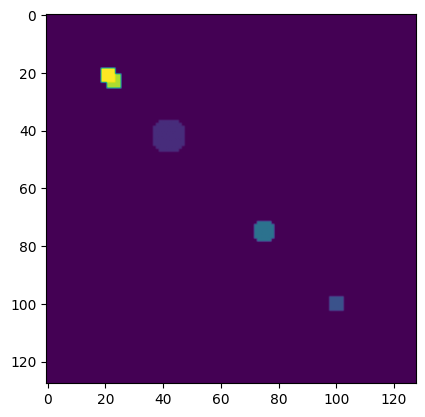

In [7]:
plt.imshow(Img_A[:,:,5])

In [10]:
Img_Out = Img_A==3

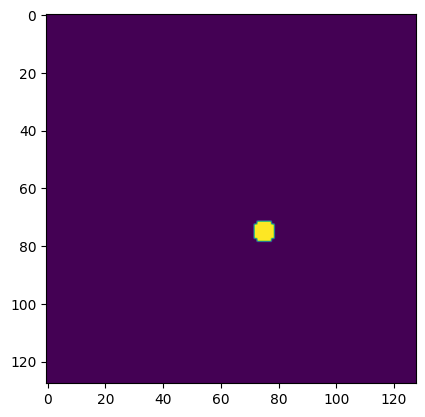

In [11]:
plt.imshow(Img_Out[:,:,5])

In [12]:
np.max(Img_Out)

True

In [10]:
assert(len(A_Objs)==len(B_Objs))

In [11]:
Overlap_Index = [n for n in range(0, len(A_Objs))]
Overlap_Index

[0, 1, 2]

In [12]:
def overlapping_objects_with_size(A_Objects, B_Objects, Img_A, Img_B):
    #return the object numbers of the overlapping objects
    Img_compare = return_overlap_segmentation(Img_A, Img_B)
    overlap_pixels = return_non_zero_pixels_from_Image(Img_compare)
    
    A_objects = []
    B_objects = []
    for coord in overlap_pixels:
        X = coord[0]
        Y = coord[1]
        Z = coord[2]
        
        A_objects.append(Img_A[X,Y,Z]) #these lines should keep the order retained of the objects
        B_objects.append(Img_B[X,Y,Z])
        
    objects_dict_A = {} ##dicts are unordered, so need to go off of a list
    objects_dict_B = {} 
    for obj in A_objects:
        obj_size = np.count_nonzero(A_objects==obj)
        objects_dict_A[obj]=obj_size
    
    for obj in B_objects:
        obj_size = np.count_nonzero(B_objects==obj)
        objects_dict_B[obj]=obj_size


In [13]:
def overlapping_objects(Img_A, Img_B):
    #return the object numbers of the overlapping objects
    Img_compare = return_overlap_segmentation(Img_A, Img_B)
    overlap_pixels = return_non_zero_pixels_from_Image(Img_compare)
    
    A_objects = []
    B_objects = []
    for n in range(0,len(overlap_pixels)):
        X = overlap_pixels[n][0]
        Y = overlap_pixels[n][1]
        Z = overlap_pixels[n][2]
        
        A_objects.append(Img_A[X,Y,Z])
        B_objects.append(Img_B[X,Y,Z])
    
    objs = list((zip(A_objects, B_objects)))
    
    return objs

In [14]:
objs = overlapping_objects(Img_A, Img_B)

In [15]:
from collections import Counter
test = Counter(objs)
#can use this dictionary to get the overlap sizes

In [16]:
test.keys()

dict_keys([(8.0, 5.0), (7.0, 5.0), (1.0, 4.0)])

In [17]:
keys = test.keys()
keys


dict_keys([(8.0, 5.0), (7.0, 5.0), (1.0, 4.0)])

In [18]:
A_objects = [ls[0] for ls in keys]

In [19]:
test.values()

dict_values([3, 38, 396])

In [20]:
objects_zip = overlapping_objects(Img_A, Img_B)

In [21]:
objects_overlap_count = Counter(objects_zip)

In [22]:
def create_overlap_df(Img_A, Img_B):
    objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
    objects_overlap_count = Counter(objects_zip)
    objects_set = objects_overlap_count.keys()
    objects_overlap_size = objects_overlap_count.values()
    A_objects = [ls[0] for ls in objects_set]
    B_objects = [ls[1] for ls in objects_set]
    A_overlap_size = list(objects_overlap_size)
    B_overlap_size = list(objects_overlap_size)
    
    Obj_A_size=[] #get the object sizes of the full object
    for obj in A_objects:
        Obj_A_size.append(get_object_size(Img_A, obj))
    print("Got Img_A object sizes")
    
    Obj_B_size=[]
    for obj in B_objects:
        Obj_B_size.append(get_object_size(Img_B, obj))
    print("Got Img_B object sizes")

  
    
    
    Overlap_Index = [n for n in range(0, len(A_objects))] #create overlap index
    
    data = {'Overlap_Index': Overlap_Index, 
       'Image_A_Object_ID': A_objects,
       'Image_B_Object_ID': B_objects,
       'Image_A_Object_Size': Obj_A_size,
       'Image_B_Object_Size': Obj_B_size,
       'Image_A_Overlap_Size': A_overlap_size,
       'Image_B_Overlap_Size': B_overlap_size}
    
    print("Built the data dict")
    
    
    df = pd.DataFrame(data)
    assert(list(df['Image_A_Overlap_Size'])==list(df['Image_B_Overlap_Size'])) ## these should be identical
    df['Image_A_Overlap_PCT'] = df['Image_A_Overlap_Size']/df['Image_A_Object_Size']
    df['Image_B_Overlap_PCT'] = df['Image_B_Overlap_Size']/df['Image_B_Object_Size']
    
    #print("Done")
    return df
    

In [23]:
data = create_overlap_df(Img_A, Img_B)

Got Img_A object sizes
Got Img_B object sizes
Built the data dict


In [24]:
data

,Overlap_Index,Image_A_Object_ID,Image_B_Object_ID,Image_A_Object_Size,Image_B_Object_Size,Image_A_Overlap_Size,Image_B_Overlap_Size,Image_A_Overlap_PCT,Image_B_Overlap_PCT
0,0,8.0,5.0,117,117,3,3,0.025641,0.025641
1,1,7.0,5.0,76,117,38,38,0.500000,0.324786
2,2,1.0,4.0,919,485,396,396,0.430903,0.816495


In [46]:
non_zero_A = (np.nonzero(Img_A))

In [47]:
obj = A_objects[0]
obj

8.0

In [48]:
obj_size_new = np.sum(Img_A == obj)
obj_size_new

117

138

In [56]:
Img_A_flat = Img_A.flatten()

In [59]:
Img_A_flat[Img_A_flat != 0]

array([8., 8., 8., ..., 2., 2., 2.])

In [60]:
obj_size = np.sum(Img_A_flat == obj)
obj_size

117

In [26]:
b = [0]*len(a)

In [31]:
objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
objects_overlap_count = Counter(objects_zip)
objects_set = objects_overlap_count.keys()
objects_overlap_size = objects_overlap_count.values()
A_objects = [ls[0] for ls in objects_set]
B_objects = [ls[1] for ls in objects_set]
A_overlap_size = list(objects_overlap_size)
B_overlap_size = list(objects_overlap_size)
time_0 = time.time()
Obj_A_size=[] #get the object sizes of the full object
for obj in A_objects:
    Obj_A_size.append(get_object_size(Img_A, obj))
time_1 = time.time()
print("Got Img_A object sizes")
print("This took: ", time_1-time_0, " seconds")

Got Img_A object sizes
This took:  0.0009477138519287109  seconds


In [32]:
objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
objects_overlap_count = Counter(objects_zip)
objects_set = objects_overlap_count.keys()
objects_overlap_size = objects_overlap_count.values()
A_objects = [ls[0] for ls in objects_set]
B_objects = [ls[1] for ls in objects_set]
A_overlap_size = list(objects_overlap_size)
B_overlap_size = list(objects_overlap_size)
time_0 = time.time()
Obj_A_size=[0]*len(A_objects) #get the object sizes of the full object
n=0
for obj in A_objects:
    Obj_A_size[n] = (get_object_size(Img_A, obj))
    n=n+1
time_1 = time.time()
print("Got Img_A object sizes")
print("This took: ", time_1-time_0, " seconds")

Got Img_A object sizes
This took:  0.0010323524475097656  seconds


[117, 76, 919]

In [ ]:
## I need to do the object sizes so it iterates thorugh the object ID list to do them, so that there are multiple values